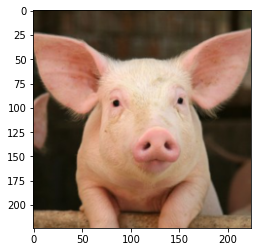

In [3]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpeg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

In [4]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/akommula2/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


In [12]:
pred = model(norm(pig_tensor))

#Should be 341 which corresponds with hog in the dataset
print(pred.max(dim=1)[1].item())

341


In [13]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [17]:
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

#Negative loss, so accuracy is 1.0 - 0.00911..

0.009114326909184456


In [19]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())
#Afterwards, the model no longer thinks the pig image is a pig

0 -0.009114326909184456
5 -0.18491391837596893
10 -13.441349983215332
15 -18.641441345214844
20 -12.373783111572266
25 -19.464115142822266
True class probability: 1.0784301229804782e-09


In [21]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", max_class)
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  348
Predicted probability: 0.9476183652877808


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


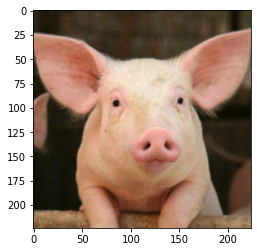

In [23]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

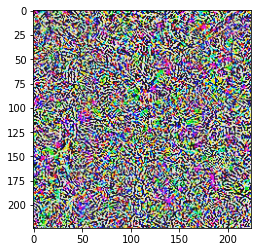

In [24]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [25]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([404])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 20.915081024169922
10 2.0706610679626465
20 -6.069150447845459
30 -17.602081298828125
40 -31.104101181030273
50 -39.544715881347656
60 -47.83391189575195
70 -52.28948974609375
80 -52.291805267333984
90 -54.113868713378906


In [30]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", max_class) #The predicted class is no longer 341, which is the code for pig. Instead, it is our desired target class 404
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

Predicted class:  404
Predicted probability: 0.9998047947883606


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


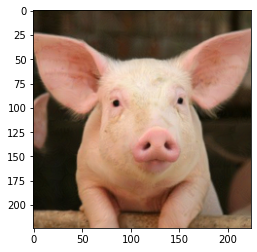

In [31]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))


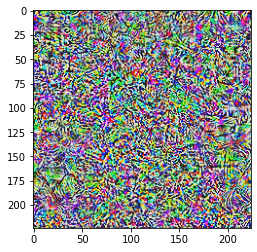

In [33]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))
